## Data Analysis

### Objective

Objective is to gather, assess, clean and subsequently briefly analyse the tweet data obtained from [WeRateDogs] twitter channel. The analysis is not meant to be definitive and scientific, especially when it comes to dog ratings actaully given, or dog stages defined within tweets, because the nature of the chanel is not to be ultimate judges.  

[WeRateDogs]: https://twitter.com/dog_rates

Of course, if someone would desparately want their dog's picture to be widely shared, they could certainly use this data to try and infer what is popular with the community and what is not, though it seems kind of evil to game the community in this way.


### Data sources
The following three data sources were used:

1. The WeRateDogs Twitter archive, provided by Udacity.

2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network, provided by Udacity

3. Each tweet's retweet count and favorite ("like") count at minimum, and any additional data queried from the Twitter API. 

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from PIL import Image
import random


%matplotlib inline

In [2]:
df_tweet = pd.read_csv('twitter_archive_master.csv')
df_class = pd.read_csv('twitter_archive_master_class.csv')
df_tweet = pd.merge(df_tweet, df_class, on=['tweet_id'], how='left')

### Examining correlation between favourite counts (likes) and retweets

I have examined correlations between all numerical variables, and identified a positive correlation between retweet_count and favourite_count (which was to be is expected). More specifically, I will examine here how the correlation looks for dogs rated with most frequently used ratings, which are between 9 and 13, and visually inspect how those correlations look for each group.

##### The chart below illustrates the numerator counts for for 5 most frequent WeRateDogs ratings (the denominator being 10):

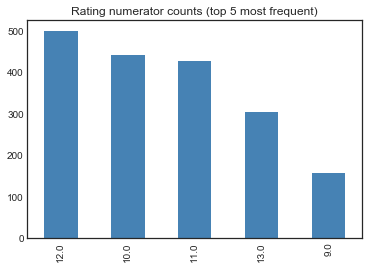

In [3]:
plt.style.use('seaborn-white')
df_like = df_tweet[['favourite_count','retweet_count','rating_numerator','rating_denominator']]
df_like = df_like[df_like.rating_numerator.notnull()]
df_like.rating_numerator.value_counts().head().plot(kind='bar', title='Rating numerator counts (top 5 most frequent)', 
                                                    color='steelblue');

##### The chart below illustrates the scatter plot for each ratings numerator:

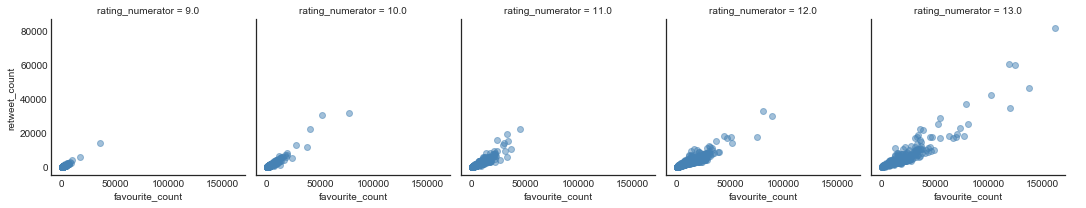

In [4]:
df_like_popular = df_like[(df_like.rating_numerator >= 9)&(df_like.rating_numerator <= 13)
                        &(df_like.rating_numerator != 9.5)&(df_like.rating_numerator != 9.75)]
g = sns.FacetGrid(df_like_popular, col="rating_numerator")
g.map(plt.scatter, "favourite_count", "retweet_count", alpha=.5, color = 'steelblue')
g.add_legend();

##### Conclusion:
We observe a positive correlation  (between favourite and retweet counts) for each rating; and it's clear that the extreme number of favourite and retweet counts have occured mostly for higher ratings (i.e. 12.0 and 13.0 in the numerator).

### Now let's see for each breed, what is the distribution of their various poularity measures.

We will look at 10 most frequently occuring breeds and distribution of their favourite ("likes") counts. I can't say that I have a null hyphothesis which should be most frequent, or most liked breeds! 


P.S. of course, if most liked dog is not a beagle, then I'm not coming back to WeRateDogs again;)

Total count of tweets that include most frequent (top 10) breeds: 635


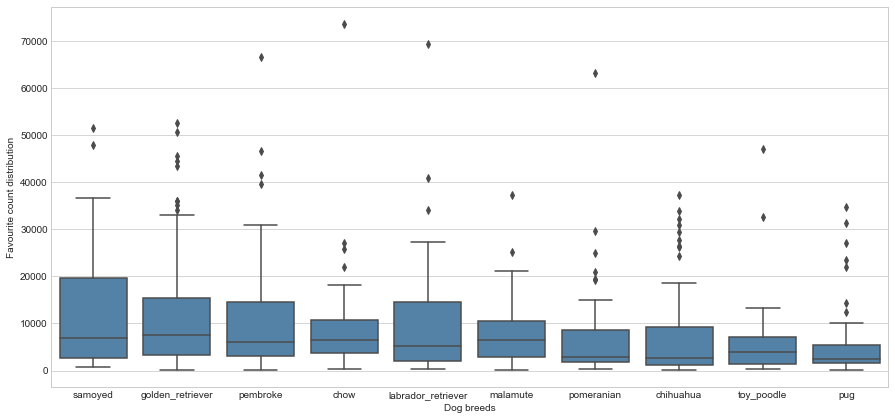

In [5]:
popular_breeds = df_tweet.breed_alt1.value_counts().head(10).index
df_breeds = df_tweet[(df_tweet.breed_alt1.isin(popular_breeds))&(df_tweet.favourite_count<=80000)]
popular_order = df_breeds.groupby(['breed_alt1'])['favourite_count'].mean().sort_values(ascending=False).index
print('Total count of tweets that include most frequent (top 10) breeds: {}'.format(df_breeds.shape[0]))

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [15,7])
ax = sns.boxplot(x="breed_alt1", y="favourite_count", data=df_breeds, order=popular_order, color='steelblue')
ax.set(xlabel='Dog breeds', ylabel='Favourite count distribution');

#### Conclusion
Samoyed breed dogs are on average most liked, while pugs are least liked, also pugs have the narrowest interquartile range.

P.S. As an owner of a beagle, any favourite charts that do not include them seems pointless! :) But there were only 17 beagles identified as most likely breed (and actually, having checked, of those many false positives) 

### Now let's see for each dog stage, what is the distribution of their various poularity measures.

This is not a perfect analysis as each tweet may have more than one dog stage (because there may be more than one dog in the tweet/photo or a single dog can belong to more than one stage). This is aalysis is therefore close approximation (which uses only first observed dog stage within a tweet text).  Having said that, dog stage itself is not a perfect science

Total count of tweets that include dog stage: 406


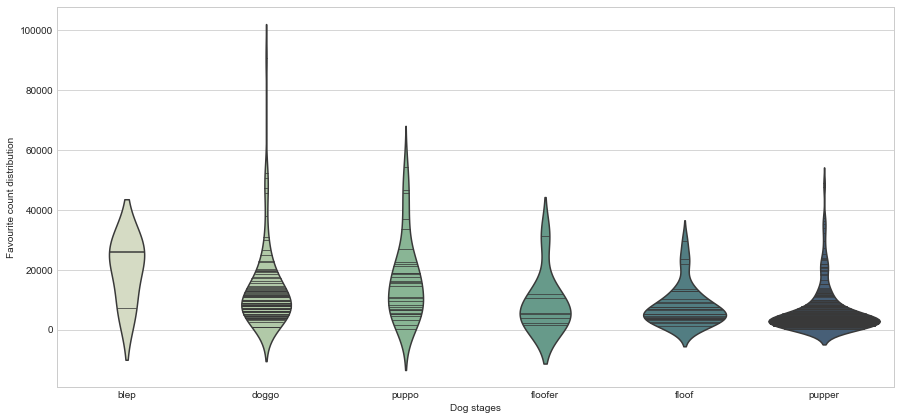

In [6]:
dog_stages = df_tweet.dog_stages_alt1.value_counts().index
df_dog_stages = df_tweet[(df_tweet.dog_stages_alt1.notnull())&(df_tweet.favourite_count<=100000)]
popular_order = df_breeds.groupby(['dog_stages_alt1'])['favourite_count'].mean().sort_values(ascending=False).index
print ('Total count of tweets that include dog stage: {}'.format(df_dog_stages.shape[0]))

plt.style.use('seaborn-whitegrid')
palette = sns.cubehelix_palette(8, start=.5, rot=-.75)
plt.figure(figsize = [15,7])

ax = sns.violinplot(x="dog_stages_alt1", y="favourite_count", data=df_dog_stages, order=popular_order,
                    inner="stick", palette=palette)
ax.set(xlabel='Dog stages', ylabel='Favourite count distribution');

#### Conclusion
- There are barely any bleps, but they rate high; 
- on average all dogs are liked equally;
- doggos have the most outliers for the better;
- puppers are most concentrated around their mean

### Finally, let's have a look at some of the 100 most liked dogs (by favourite count) aka Top Dogs

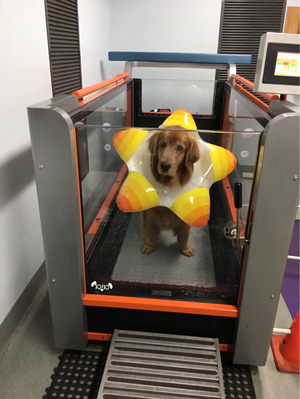

This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF

Favourite count: 64097
Retweet count: 14174



In [21]:
#let's disploy the image of selected Top Dog
fav_index = df_tweet.favourite_count.sort_values(ascending=False).head(100).index
top_dog = random.sample(list(fav_index),k=1)[0]

url = df_tweet.loc[top_dog]['dog_picture_url']
text = df_tweet.loc[top_dog]['text']
fav_count = df_tweet.loc[top_dog]['favourite_count']
retweet_count = df_tweet.loc[top_dog]['retweet_count']


r = requests.get(url)
basewidth = 300
img = Image.open(BytesIO(r.content))
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
display(img)

print(text)
print()
print('Favourite count: {}\nRetweet count: {}\n'.format(int(fav_count),int(retweet_count)))

### And let's definitely check out a beagle or two!

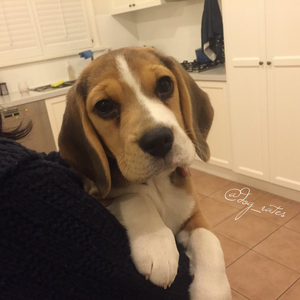

This is Tove. She's a Balsamic Poinsetter. Surprisingly deadly. 12/10 snug with caution https://t.co/t6RvnVEdRR

Breed: beagle
Favourite count: 5426
Retweet count: 1292



In [22]:
#let's disploy the image of selected Top Dog
beagle_index = df_tweet[df_tweet.breed_alt1 == 'beagle'].index
beagle = random.sample(list(beagle_index),k=1)[0]

url = df_tweet.loc[beagle]['dog_picture_url']
text = df_tweet.loc[beagle]['text']
fav_count = df_tweet.loc[beagle]['favourite_count']
retweet_count = df_tweet.loc[beagle]['retweet_count']
breed = df_tweet.loc[beagle]['breed_alt1']


r = requests.get(url)
basewidth = 300
img = Image.open(BytesIO(r.content))
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
display(img)

print(text)
print()
print('Breed: {}\nFavourite count: {}\nRetweet count: {}\n'.format(breed,int(fav_count),int(retweet_count)))